In [1]:
import sys
import lzma
from s2clientprotocol.sc2api_pb2 import Response, ResponseObservation
from MapAnalyzer.utils import import_bot_instance
from MapAnalyzer import MapData
import pickle
import numpy as np
import matplotlib.pyplot as plt
sys.path.append("src")
sys.path.append("src/ares")
from rust_helpers import number_of_chokes_pathed_through, terrain_flood_fill
%load_ext line_profiler
%load_ext Cython

C:\Users\Tom\AppData\Local\pypoetry\Cache\virtualenvs\ares-sc2-S437wHWG-py3.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
BERLINGRAD = "tests/pickle_data/BerlingradAIE.xz"

In [3]:
with lzma.open(BERLINGRAD, "rb") as f:
    raw_game_data, raw_game_info, raw_observation = pickle.load(f)
bot = import_bot_instance(raw_game_data, raw_game_info, raw_observation)
data = MapData(bot)

2023-05-05 11:05:16.181 | INFO     | MapAnalyzer.MapData:__init__:122 - dev Compiling Berlingrad AIE 
 Version dev Map Compilation Progress : 0.4it [00:00,  1.57it/s]


In [4]:
dtype = [
    ('type_id', "U32"),
    ('is_ready', np.bool_),
    ('is_idle', np.bool_),
]

In [5]:
def f():
    return np.vectorize(lambda unit: u.type_id, u.is_ready, u.is_idle)
    # return np.array(
    #         [(u.type_id, u.is_ready, u.is_idle) for u in all_units],
    #         dtype=dtype
    #     )

In [6]:
%timeit -r 100 -n 10 f()

NameError: name 'u' is not defined

In [ ]:
%timeit -r 100000 -n 10 np.where((all_units_np["is_ready"] & all_units_np["is_idle"]))

NameError: name 'all_units_np' is not defined

In [ ]:
units = bot.units + bot.mineral_field

In [ ]:
custom_units = units.filter(lambda u: u.is_idle and u.is_ready)

In [ ]:
%timeit -r 10000 -n 10 units.filter(lambda u: u.is_idle and u.is_ready)

In [ ]:
%timeit -r 10000 -n 10 [unit for unit in all_units if unit.is_idle and unit.is_ready]

In [ ]:
def for_loop(units):
    custom_units = []
    for unit in units:
        if unit.is_ready and unit.is_idle:
            custom_units.append(unit)
%timeit -r 10000 -n 10 for_loop(units)

In [ ]:
%timeit -r 10000 -n 10 np.array(units)

In [ ]:
_units[0]

In [ ]:
%timeit -r 1000 -n 5 [unit for unit in _units if unit.is_idle and unit.is_ready]

In [ ]:
%%cython --annotate
from cython cimport boundscheck, wraparound
# The boundscheck(False) decorator tells Cython that we know that we will not access elements outside the bounds of the units list, which allows for faster indexing. 
# The wraparound(False) decorator tells Cython that we know that we will not use negative indices to access elements of the list, which also allows for faster indexing.
@boundscheck(False)
@wraparound(False)
cpdef list for_loop_cython(units, expression):
    cdef object[:] custom_units = [unit for unit in units if expression(unit)]
    # cdef list custom_units = [unit for unit in units if expression(unit)]
    return custom_units

In [ ]:
%timeit -r 10000 -n 10 for_loop_cython(units, lambda u: u.is_idle and u.is_ready)

In [ ]:
%timeit -r 1000 -n 10 for_loop_cython(units)

# FLOOD FILL

In [7]:
choke_points = set(
            [point for ch in data.map_chokes for point in ch.points]
        )

In [8]:
start_point=bot.enemy_start_locations[0].rounded
terrain_grid=bot.game_info.terrain_height.data_numpy.T
pathing_grid=data.get_pyastar_grid().astype(np.uint8)
max_distance=20
choke_points=set(
        [point for ch in data.map_chokes for point in ch.points]
    )
def _terrain_flood_fill():
    return terrain_flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points)

In [9]:
%timeit -r 1000 -n 5 _terrain_flood_fill()

906 µs ± 17.2 µs per loop (mean ± std. dev. of 1000 runs, 5 loops each)


In [10]:
%prun -s cumulative _terrain_flood_fill()

         5 function calls in 0.001 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.001    0.001 {built-in method builtins.exec}
        1    0.000    0.000    0.001    0.001 <string>:1(<module>)
        1    0.000    0.000    0.001    0.001 1454001475.py:8(_terrain_flood_fill)
        1    0.001    0.001    0.001    0.001 {built-in method rust_helpers.terrain_flood_fill}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}

In [11]:
%lprun -f _terrain_flood_fill _terrain_flood_fill()

Timer unit: 1e-07 s

Total time: 0.001463 s
File: C:\Users\Tom\AppData\Local\Temp\ipykernel_13160\1454001475.py
Function: _terrain_flood_fill at line 8

Line #      Hits         Time  Per Hit   % Time  Line Contents
     8                                           def _terrain_flood_fill():
     9         1      14630.0  14630.0    100.0      return terrain_flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points)

In [12]:
def grid_flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points):
    pass

In [13]:
def euclidean_distance_squared_py(p1, p2):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2

In [14]:
%%cython --annotate
cpdef float euclidean_distance_squared((float, float) p1, (float, float) p2):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2

In [15]:
%timeit -r 100 -n 5 euclidean_distance_squared((50.0, 50.0), (100.0, 100.0))

146 ns ± 50 ns per loop (mean ± std. dev. of 100 runs, 5 loops each)


In [16]:
%timeit -r 100 -n 5 euclidean_distance_squared_py((50.0, 50.0), (100.0, 100.0))

576 ns ± 119 ns per loop (mean ± std. dev. of 100 runs, 5 loops each)


In [17]:
euclidean_distance_squared((50.0, 50.0), (100.0, 100.0))

5000.0

In [18]:
%%cython --annotate
from cython cimport boundscheck, wraparound

cdef unsigned int euclidean_distance_squared_int((unsigned int, unsigned int) p1, (unsigned int, unsigned int) p2):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2

cpdef set flood_fill(
    (unsigned int, unsigned int) start_point, 
    const unsigned char[:, :] terrain_grid, 
    const unsigned char[:, :] pathing_grid, 
    unsigned int max_distance, 
    set choke_points
):
    cdef:
        unsigned int terrain_height = terrain_grid[start_point[0], start_point[1]]
        unsigned int pathing_value = pathing_grid[start_point[0], start_point[1]]
        set filled_points = set()

    # Only continue if we can get a height for the starting point
    if not terrain_height:
        return filled_points
    
    if pathing_value != 1:
        return filled_points
        
    grid_flood_fill(start_point, terrain_grid, pathing_grid, terrain_height, filled_points, start_point, max_distance, choke_points)
    return filled_points

cdef set grid_flood_fill(
    (unsigned int, unsigned int) point, 
    const unsigned char[:, :] terrain_grid, 
    const unsigned char[:, :] pathing_grid, 
    unsigned int target_val, 
    set current_vec, 
    (unsigned int, unsigned int) start_point, 
    unsigned int max_distance, 
    set choke_points):
    cdef:
        unsigned int terrain_height = terrain_grid[start_point[0], start_point[1]]
        unsigned int pathing_value = pathing_grid[start_point[0], start_point[1]]
    # Check that we haven't already added this point.
    if point in current_vec:
        return current_vec

    # Check that this point isn't too far away from the start
    if euclidean_distance_squared_int(point, start_point) > max_distance ** 2:
        return current_vec

    if point in choke_points:
        return current_vec

    terrain_height = terrain_grid[point[0], point[1]]
    pathing_value = pathing_grid[point[0], point[1]]
    if terrain_height != target_val or pathing_value != 1:
        return current_vec
    
    current_vec.add(point)
    grid_flood_fill((point[0]+1, point[1]), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, choke_points)
    grid_flood_fill((point[0]-1, point[1]), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, choke_points)
    grid_flood_fill((point[0], point[1]+1), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, choke_points)
    grid_flood_fill((point[0], point[1]-1), terrain_grid, pathing_grid, terrain_height, current_vec, start_point, max_distance, choke_points)

In [19]:
%timeit -r 1000 -n 5 _terrain_flood_fill()

910 µs ± 24.8 µs per loop (mean ± std. dev. of 1000 runs, 5 loops each)


started at 3 ms

In [20]:
%timeit -r 10 -n 5 flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points)

340 µs ± 42.6 µs per loop (mean ± std. dev. of 10 runs, 5 loops each)


In [21]:
new_flood_fill = flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points)

In [22]:
len(new_flood_fill)

706

In [23]:
original_flood_fill = _terrain_flood_fill()

In [24]:
len(original_flood_fill)

706

In [25]:
g = pathing_grid.copy()
h = pathing_grid.copy()
for value in original_flood_fill:
    g[value] = 25
for value in new_flood_fill:
    h[value] = 25

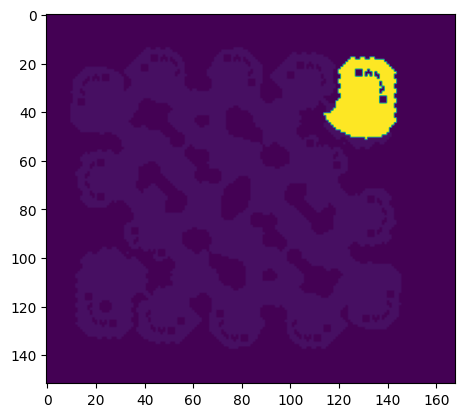

In [26]:
plt.imshow(g)

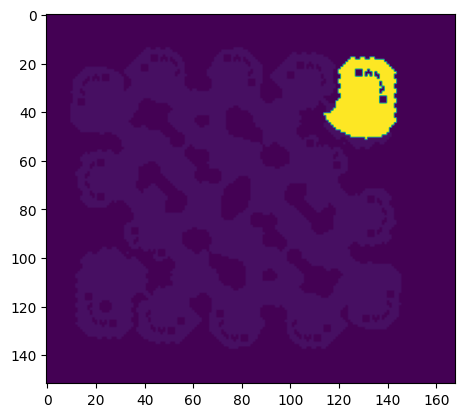

In [27]:
plt.imshow(h)

# Find Building locations

In [28]:
%%cython --annotate
from cython cimport boundscheck, wraparound
# The boundscheck(False) decorator tells Cython that we know that we will not access elements outside the bounds of the units list, which allows for faster indexing. 
# The wraparound(False) decorator tells Cython that we know that we will not use negative indices to access elements of the list, which also allows for faster indexing.
@boundscheck(False)
@wraparound(False)
cpdef ((float, float), (float, float)) get_bounding_box(set coordinates):
    cdef:
        float x_min = 9999.0
        float x_max = 0.0
        float x_val = 0.0
        float y_min = 9999.0
        float y_max = 0.0
        float y_val = 0.0
        int start = 0
        int stop = len(coordinates)
        (float, float) position
    for i in range(start, stop):
        position = coordinates.pop()
        x_val = position[0]
        y_val = position[1]
        if x_val < x_min:
            x_min = x_val
        if x_val > x_max:
            x_max = x_val
        if y_val < y_min:
            y_min = y_val
        if y_val > y_max:
            y_max = y_val
    return (x_min, x_max), (y_min, y_max)

In [29]:
%timeit -r 1000 -n 10 get_bounding_box(flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points))

343 µs ± 10.8 µs per loop (mean ± std. dev. of 1000 runs, 10 loops each)


In [30]:
raw_x_bounds, raw_y_bounds = get_bounding_box(flood_fill(start_point, terrain_grid, pathing_grid, max_distance, choke_points))

In [31]:
raw_x_bounds

(18.0, 51.0)

In [32]:
%%cython --annotate

from scipy.signal import convolve2d
import numpy as np
cimport numpy as np

cpdef find_building_locations(
    np.ndarray[np.uint8_t, ndim=2] kernel,
    int x_stride,
    int y_stride,
    (int, int) x_bounds,
    (int, int) y_bounds,
    const unsigned char[:, :] creep_grid,
    const unsigned char[:, :] placement_grid,
    const unsigned char[:, :] vision_grid,
    const float[:, :] pathing_grid,
    const unsigned char[:, :] points_to_avoid_grid,
    unsigned int building_width,
    unsigned int building_height,
    bint include_addon = False,
    unsigned int kernel_padding = 0
):
    """
    Use a convolution pass to find all possible building locations in an area
    See full docs in `placement_solver.pyi`
    """
    cdef:
        unsigned int i = 0
        unsigned int j = 0
        unsigned int _x = 0
        unsigned int _y = 0
        unsigned int valid_idx = 0
        float x, y
        float weighted_x, weighted_y
        int x_min = x_bounds[0]
        int x_max = x_bounds[1]
        int y_min = y_bounds[0]
        int y_max = y_bounds[1]
        int area = building_height * building_width
        unsigned char[:, :] to_convolve = np.zeros((x_max - x_min + 1, y_max - y_min + 1), dtype=np.uint8)
        (float, float) [500] valid_spots
        (float, float) center
        float half_width = building_width / 2

    for i in range(x_min, x_max + 1):
        for j in range(y_min, y_max + 1):
            if points_to_avoid_grid[j][i] == 0 and creep_grid[j][i] == 0 and placement_grid[j][i] == 1 and pathing_grid[j][i] == 1:
                to_convolve[i - x_min][j - y_min] = 1
                
    if kernel_padding:
        # create a new kernel with values larger than the target value
        old_kernel_size = kernel.shape[0]
        new_kernel_dim = 2 * kernel_padding + kernel.shape[0]
        kernel = (area + 1) * np.ones((new_kernel_dim, new_kernel_dim), dtype=np.uint8)
        # set the original kernel points back to 1 so we can still check placements
        for i in range(kernel_padding, kernel_padding + old_kernel_size):
            for j in range(kernel_padding, kernel_padding + old_kernel_size):
                kernel[i][j] = 1
        print(kernel)

    cdef unsigned char[:, :] result = convolve2d(to_convolve, kernel, mode="valid")

    for i in range(0, result.shape[0], x_stride):
        for j in range(0, result.shape[1], y_stride):
            if result[i][j] == area:
                x = i + x_min + half_width
                y = j + y_min + half_width

                if include_addon:
                    _x = int(x + 3.5)
                    _y = int(y - 1.5)
                    # check placement of edge of addon
                    if placement_grid[_y][_x] == 0 or creep_grid[_y][_x] == 1 or pathing_grid[_y][_x] == 0 or points_to_avoid_grid[_y][_x] == 1:
                        continue
                    if placement_grid[_y-1][_x] == 0 or creep_grid[_y-1][_x] == 1 or pathing_grid[_y-1][_x] == 0 or points_to_avoid_grid[_y-1][_x] == 1:
                        continue
                    if placement_grid[_y+1][_x] == 0 or creep_grid[_y+1][_x] == 1 or pathing_grid[_y+1][_x] == 0 or points_to_avoid_grid[_y+1][_x] == 1:
                        continue
                # valid building placement is building center, so add half to x and y
                valid_spots[valid_idx][0] = x
                valid_spots[valid_idx][1] = y
                valid_idx += 1

            if valid_idx >= 500:
                # we've reached the maximum number of valid spots
                break

    if valid_idx == 0:
        return [], (0, 0)

    i = 0
    for i in range(0, valid_idx):
        weighted_x += valid_spots[i][0]
        weighted_y += valid_spots[i][1]

    center = (weighted_x / valid_idx, weighted_y / valid_idx)

    return list(valid_spots)[:valid_idx], center

In [70]:
kernel: np.ndarray = np.ones(
            (3, 3), dtype=np.uint8
        )

points_to_avoid_grid = np.zeros(bot.game_info.placement_grid.data_numpy.shape, dtype=np.uint8)

# avoid within 5.5 distance of base location
start_x = int(bot.townhalls[0].position.x - 5.5)
start_y = int(bot.townhalls[0].position.y - 5.5)

points_to_avoid_grid[start_x:start_x+11, start_y:start_y+11] = 1

production_positions, _center = find_building_locations(
    kernel, 
    5,
    3,
    raw_x_bounds, 
    raw_y_bounds, 
    bot.state.creep.data_numpy, 
    bot.game_info.placement_grid.data_numpy, 
    bot.state.visibility.data_numpy, 
    data.get_pyastar_grid(),
    # bot.game_info.pathing_grid.data_numpy, 
    points_to_avoid_grid, 
    3, 
    3,
    True,
    2
)

[[10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10]
 [10 10  1  1  1 10 10]
 [10 10  1  1  1 10 10]
 [10 10  1  1  1 10 10]
 [10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10]]


In [71]:
production_positions

[]